# AMBROSM 코드 리뷰
* [링크](https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense)
* contents
    * a little bit of EDA
    * how to cross_validate correctly
    * how to preprocess the data for various classifiers
    * how to tune the most important hyperparameters of some models
    * how an ensemble performs better than any single model

## Reading the data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

np.set_printoptions(linewidth=195, edgeitems=5)

In [2]:
base_path = '../../data/'

# train_df = pd.read_csv(base_path + 'train.csv', index_col='id')
# test_df = pd.read_csv(base_path + 'test.csv', index_col='id')
train_df = pd.read_csv(base_path + 'train_f1.csv', index_col='id')
test_df = pd.read_csv(base_path + 'test_f1.csv', index_col='id')
submission_df = pd.read_csv(base_path + 'sample_submission.csv', index_col='id')
original_df = pd.read_csv(base_path + 'jm1.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101762 entries, 0 to 101762
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101762 non-null  float64
 1   v(g)               101762 non-null  float64
 2   ev(g)              101762 non-null  float64
 3   iv(g)              101762 non-null  float64
 4   n                  101762 non-null  float64
 5   v                  101762 non-null  float64
 6   l                  101762 non-null  float64
 7   d                  101762 non-null  float64
 8   i                  101762 non-null  float64
 9   e                  101762 non-null  float64
 10  b                  101762 non-null  float64
 11  t                  101762 non-null  float64
 12  lOCode             101762 non-null  int64  
 13  lOComment          101762 non-null  int64  
 14  lOBlank            101762 non-null  int64  
 15  locCodeAndComment  101762 non-null  int64  
 16  uniq_Op

In [4]:
train_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'defects', 'outlier_count'],
      dtype='object')

In [5]:
original_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [6]:
from IPython.core.display_functions import display

with pd.option_context("display.min_rows", 7):
    display(train_df)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,defects,outlier_count
id,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,0,0,16.0,9.0,False,0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,0,0,11.0,11.0,False,0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,0,0,12.0,11.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,0.12,327.43,20,0,1,0,10.0,8.0,False,0
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,0.06,85.22,7,0,0,0,11.0,14.0,False,0
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,0.57,4278.43,102,1,2,0,22.0,31.0,False,1


## EDA
* defects는 target column, 21개의 다른 컬럼이 features다. 모든 features는 numerical하다.
* no missing values(train_df.isna().sum().sum())
* no duplicated(train_df.duplicated().sum())
* somewhat unbalanced(23%), use StratifiedKFold for cross-validation, upsampling, downsampling 불필요
* 10000라인 이상이다. 몇몇 알고리즘한테는 너무 크다.(e.g. kernel methods, neighborhood, components analysis)
* 10000라인 이상, 21개의 feature 이므로 풍부한 데이터 이다. 오버피팅을 걱정할 필요가 없다.
### 2가지 포인트
* original과 합성 데이터에는 중요한 차이가 있다. 이 문서에서는 original 데이터는 포함하지 않는다.
* 21개의 feature 모두 양수이고 분포는 right-skewed 하다. exponential distribution(지수분포)와 비슷핟. log transformation이 필요하다.

In [7]:
train_df.duplicated().sum()

650

In [8]:
dup_test = pd.DataFrame([[1,2,3],[4,5,6],[1,2,3]])
dup_test.duplicated()

0    False
1    False
2     True
dtype: bool

## original과 합성 데이터의 차이
* train과 test 데이터는 original 데이터 셋에 기반해 합성데이터로 구성된다. 분포는 같이 않다.
* original 데이터는 9개의 파생 데이터가 있다.
```
P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
V = volume on minimal implementation = (2 + mu2')log2(2 + mu2')
L = program length = V*/N
D = difficulty = 1/L
L' = 1/D
I = intelligence = L'*V'
E = effort to write program = V/L
T = time to write program = E/18 seconds
```
* origin 데이터가 합성데이터에 완전히 반영되지는 않음(아래 차트 확인)
* 최종 defects의 비율도 다름

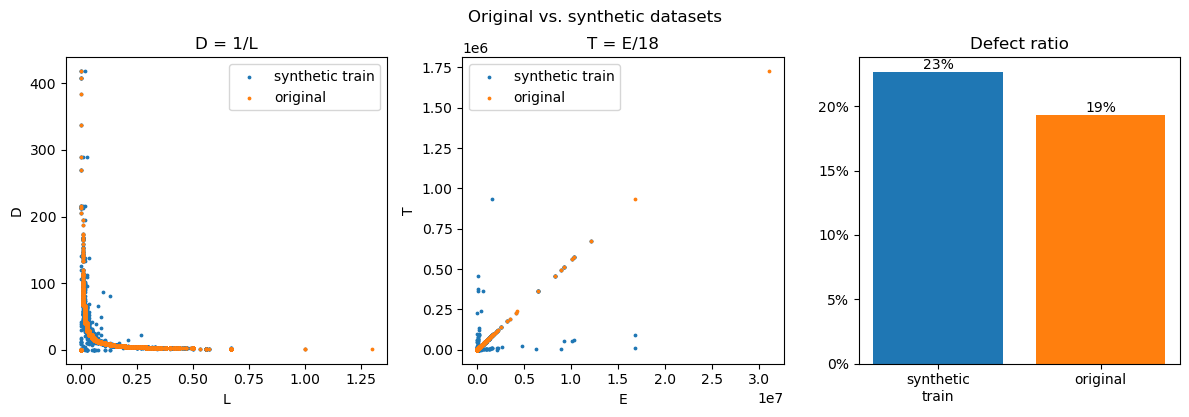

In [9]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(train_df.l, train_df.d, s=3, label='synthetic train')
ax1.scatter(original_df.l, original_df.d, s=3, label='original')
ax1.set_xlabel('L')
ax1.set_ylabel('D')
ax1.set_title('D = 1/L')
ax1.legend()
ax2.scatter(train_df.e, train_df.t, s=3, label='synthetic train')
ax2.scatter(original_df.e, original_df.t, s=3, label='original')
ax2.set_xlabel('E')
ax2.set_ylabel('T')
ax2.set_title('T = E/18')
ax2.legend()
bars1 = ax3.bar([0], [train_df.defects.mean()*100])
bars2 = ax3.bar([1], [original_df.defects.mean()*100])
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax3.bar_label(bars1, fmt='{:.0f}%')
ax3.bar_label(bars2, fmt='{:.0f}%')
ax3.set_xticks([0, 1], ['synthetic\ntrain', 'original'])
ax3.set_title('Defect ratio')
plt.tight_layout()
plt.suptitle('Original vs. synthetic datasets', y=1.03)
plt.show()

### 인사이트 : 위의 차이점을 봤을때 훈련 모델에 original 데이터를 사용하는 것을 추천하지 않음

## log-transformation 추천

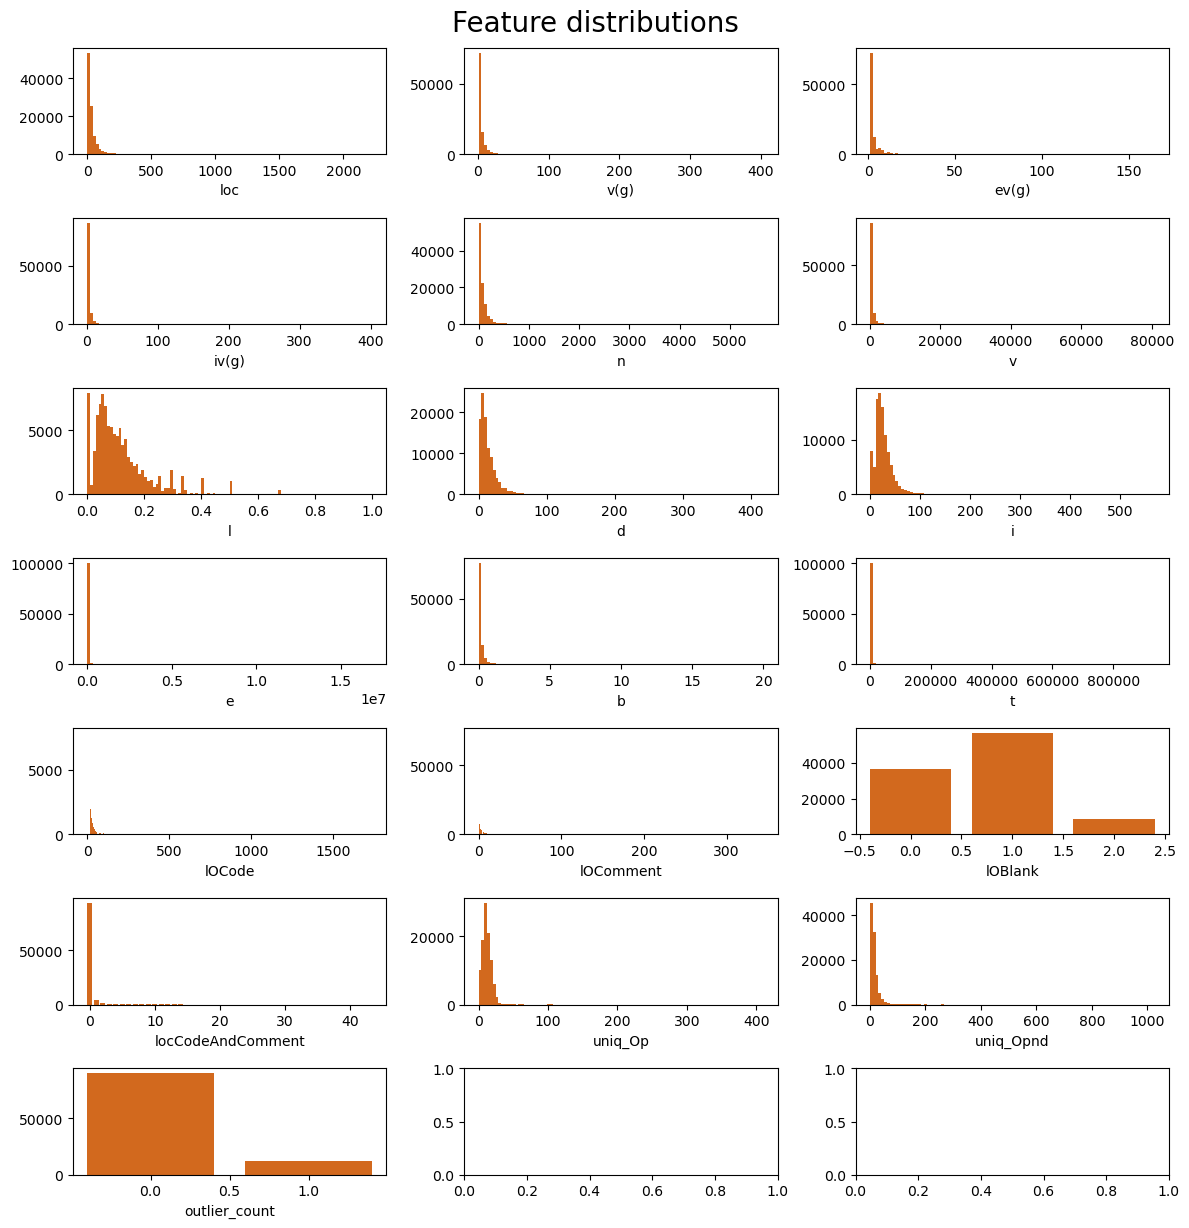

In [10]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    if train_df[col].dtype == float:
        ax.hist(train_df[col], bins=100, color='chocolate')
    else: #int
        vc = train_df[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

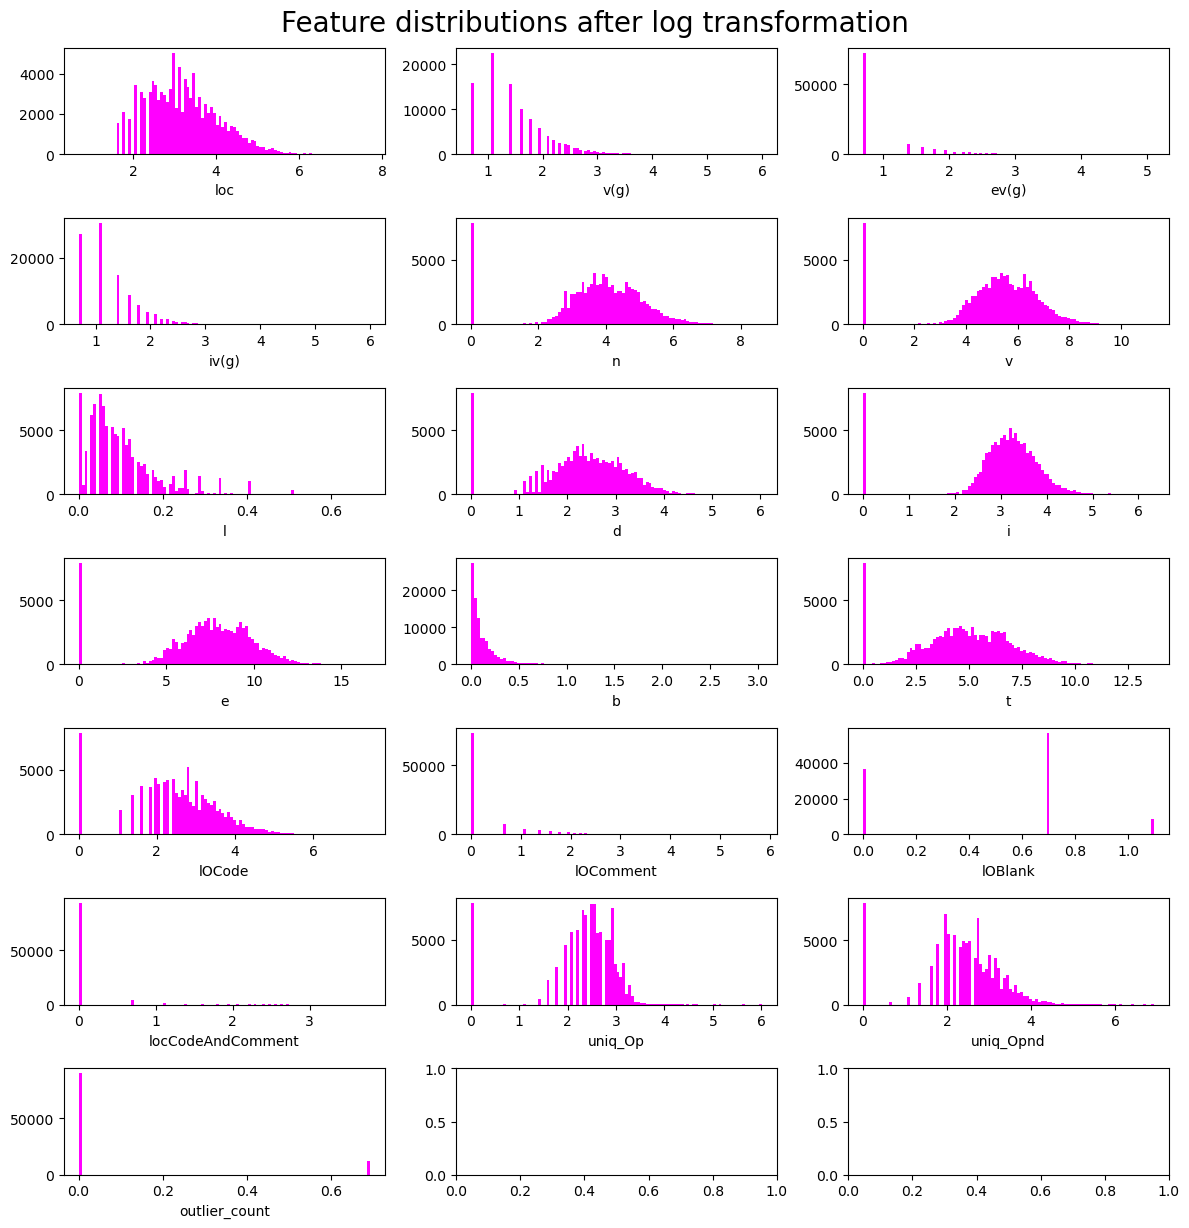

In [11]:
# 로그 함수 적용
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    ax.hist(np.log1p(train_df[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

## Cross-validatoin

In [12]:
result_list = []
def cross_val(model, label):
    """
    Cross-validate the model with a StratifiedKFold

    The cross-validation score is printed and added to the global result_list
    :param model: 훈련 모델
    :param label: cross_val을 대표하는 이름
    :return: auc
    """
    start_time = datetime.now()
    k_fold = StratifiedKFold(shuffle=True, random_state=61)
    oof = np.full(len(train_df), np.nan)
    auc_list = []
    for fold_idx, (train_idx, val_idx) in enumerate(k_fold.split(train_df, train_df.defects)):
        X_train = train_df.iloc[train_idx]
        X_val = train_df.iloc[val_idx]
        y_train = X_train.pop('defects')
        y_val = X_val.pop('defects')
        model.fit(X_train, y_train)
        # try:
        y_val_pred = model.predict_proba(X_val)[:, 1]
        # except AttributeError:
        #     y_val_pred = model.decision_function(X_val)
        oof[val_idx] = y_val_pred
        auc = roc_auc_score(y_val, y_val_pred)
        auc_list.append(auc)
    auc = np.mean(auc_list)
    execution_time = datetime.now() - start_time
    print(f"{label}, # AUC {auc:.5f}, time={str(execution_time)[-15:-7]}")
    result_list.append((auc, label, execution_time))
    return auc, oof

In [13]:
pop_df = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6], 'c':[7,8,9]})
print(pop_df.pop('b'))
print(pop_df)

0    4
1    5
2    6
Name: b, dtype: int64
   a  c
0  1  7
1  2  8
2  3  9


In [14]:
def plot_score_list(score_list, label, parameter, xscale='linear'):
    """
    show a scatterplot of the scores in the global variable score_list
    :param label: 출력 이름
    :param score_list: score list
    :param parameter: 파라미터 이름
    :param xscale: 스케일 정보, linear or log
    :return: None
    """
    plt.figure(figsize=(6,3))
    plt.scatter([p for p, _ in score_list], [s for _, s in score_list])
    plt.xscale(xscale)
    plt.xlabel(f"{parameter}{' (log-scale)' if xscale=='log' else ''}")
    plt.ylabel('AUC score')
    plt.title(label)
    plt.show()

## A few models
### LinearSVC and LogisticRegression
* LinearSVC, LogisticRegression은 대개 파이프라인을 통해 StandardScaler후에 사용됨
* Linear 모델들은 종종 다항식 feature를 추가하면 개선된다. 데이터셋은 21개의 피처를 가지기 때문에, 파이프라인을 통해 StrandardScaler 전에 `PolynomialFeatures(include_bias=False)`를 실행함으로써 two features의 결과를 추가할 수 있다, 데이터셋은 252 피처로 폭발함
* 두 알고리즘의 문서에 의하면 `n_samples > n_features`일 경우 dual=False를 선호함
* Regularization은 C에 의해 컨트롤됨(low C = high regularization)
* logistic regression에서 `solver-cholesy`는 주어진 데이터셋에서 가장 빠른 solver임
* 우리의 데이터셋에서 LogisticRegression은 `class_wegith='balanced'`로 설정할 때 가장 좋은 점수를 받았다. 모든 예측된 확률은 너무 높겠지만 auc score를 망가뜨리진 않을거다.

In [18]:
# LinearSVC
score_list = []
linear_best_oof = None
linear_best_model = None
max_auc = 0
for idx, C in enumerate(np.logspace(-4, -1, 4)):
    auc, oof = cross_val(
        make_pipeline(
            FunctionTransformer(np.log1p),
            PolynomialFeatures(2, include_bias=False),
            StandardScaler(),
            CalibratedClassifierCV(LinearSVC(dual=False, C=C))
        ),
        f'Poly-LinearSVC {C=:.2g}'
    )
    if idx==0 or max_auc<auc:
        max_auc = auc
        linear_best_oof = oof
    score_list.append((C, auc))
plot_score_list(score_list, 'Poly-LinearSVC', 'C', 'log')
# 0.78858

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'with_mean'

In [ ]:
np.logspace(-4,-1,4)  # 10^-4 ~ 10^-1 사이에 4개의 값을 리턴

In [ ]:
polynomal_tranformer = PolynomialFeatures(2, include_bias=False)
r = polynomal_tranformer.fit_transform(train_df)
pd.DataFrame(r).head(5)

In [ ]:
# LogisticRegression
score_list = []
logistic_best_oof = None
max_auc = 0
for idx, C in enumerate(np.logspace(-2, 1, 9)):
    auc, oof = cross_val(
        make_pipeline(
            FunctionTransformer(np.log1p),
            PolynomialFeatures(2, include_bias=False),
            StandardScaler(),
            LogisticRegression(
                dual=False,
                C=C,
                class_weight='balanced',
                max_iter=1500,
                random_state=61,
                solver='newton-cholesky'
            )
        ),
        f'Poly-LogisticRegression {C=:.2g}',
    )
    if idx==0 or max_auc<auc:
        max_auc = auc
        logistic_best_oof = oof
    score_list.append((C, auc))

plot_score_list(score_list, 'Poly-LogisticRegression', 'C', 'log')

## Kernel approximation
* Kernel methods는 캐글에서 외면되지만 현재 대회에서는 사용할 것이다.
* 2가지 특징에 기반한다.
    * 선형 머신러닝 모델은 대부분의 머신러닝 작업이 비선형 솔루션을 요구하기 때문에 제한된다.
    * 선형 머신러닝 알고리즘은 일반적으로 훈련과 테스트 데이터에 벡터 공간에서 선형 동작에만 적용한다.
* 커널에 기반한 수학은 계산하는데 시간이 걸리지만, 주요 아이디어는 데이터가 고차원 벡터 공간에 비선형으로 맵된다는 것이다. 고차원에 의해 선형 분류기는 좋은 결정 표면을 찾는데 많은 자유도를 요구한다. kernel methods는 선형 분류기에 대한 비선형 피처를 생성하는 자동화된 피처 엔지니어링이라고 생각할 수 있다.
* kernel methods에 단점은 복잡도이다. 계산하는데 너무 많은 시간과 메모리를 소비한다.
* Kernel approximation(커널 근사치)는 kernel methods의 단점을 보안해 더 적은 비용으로 비슷한 성능을 가진다.
* 다음 예제에서는 kernel approximation(Nyström approximation)를 활용한다.

In [ ]:
score_list = []
n_components = 400
logistic_nystroem_best_oof = None
max_auc = 0
for idx, C in enumerate(np.logspace(-3, -2, 9)):
    auc, oof = cross_val(
        make_pipeline(
            FunctionTransformer(np.log1p),
            Nystroem(n_components=n_components, random_state=61), # gamma = 1/21
            StandardScaler(),
            LogisticRegression(
                dual=False,
                C=C,
                class_weight='balanced',
                max_iter=1500,
                random_state=61,
                solver='newton-cholesky'
            )
        ),
        f'Nyström-LogisticRegression {n_components=} {C=:.2g}'
    )
    score_list.append((C, auc))
    if idx==0 or max_auc<auc:
        max_auc = auc
        logistic_nystroem_best_oof = oof
plot_score_list(score_list, 'Nyström LogisticRegression', 'C', 'log')

## ExtraTreesClassifier
* 알아둘 점
    * ExtraTreesClassifier의 가장 중요한 하이퍼파라미터는 min_samples_leaf 이다.
        * high min_samples_leaf : 빠르지만 underfit
        * low min_samples_leaf : 느리고 overfit
    * max_features를 1.0으로 설정정하는 것은 대개 기본값이 `sqrt`보다 더 좋은 auc scores를 준다. 대신 훈련하는데 느리다.

In [ ]:
score_list = []
extra_best_oof = None
max_auc = 0
for idx, min_samples_leaf in enumerate([120, 130, 140]):
    auc, oof = cross_val(
        make_pipeline(
            FunctionTransformer(np.log1p),
            ExtraTreesClassifier(
                n_estimators=100,
                min_samples_leaf=min_samples_leaf,
                max_features=1.0,
                random_state=61
            ),
        ),
        f"ET {min_samples_leaf=}"
    )
    score_list.append((min_samples_leaf, auc))
    if idx==0 or max_auc<auc:
        max_auc = auc
        extra_best_oof = oof

plot_score_list(score_list, 'ExtraTreesClassifier', 'min_samples_leaf')

## RandomForestClassifier
* 알아둘 점
    * rf의 가장 중요한 하이퍼파라미터는 `min_samples_leaf`이다
        * high min_samples_leaf : 빠르지만 underfit
        * low min_samples_leaf : 누리고 overfit
    * max_features를 1.0으로 설정정하는 것은 대개 기본값이 `sqrt`보다 더 좋은 auc scores를 준다. 대신 훈련하는데 느리다.

In [ ]:
# RandomForestClassifer
score_list = []
rf_best_oof = None
max_auc = 0
for idx, min_samples_leaf in enumerate([180, 190, 220, 230, 250]):
    auc, oof = cross_val(
        RandomForestClassifier(
            n_estimators=100,
            min_samples_leaf=min_samples_leaf,
            max_features=1.0,
            random_state=61,
        ),
        f'RF {min_samples_leaf=}'
    )
    score_list.append((min_samples_leaf, auc))
    if idx==0 or max_auc<auc:
        max_auc = auc
        rf_best_oof = oof
plot_score_list(score_list, 'RandomForestClassifier', 'min_samples_leaf')

## KNeighborsClassifier
* 알아둘 점
    * KNeighborsClassifier는 대개 StandardScaler 후에 사용한다.
    * 가장 중요한 하이퍼파라미터는 `n_neighbors` 이다.

In [ ]:
# KNeighborsClassifier
score_list = []
knn_best_oof = None
max_auc = 0
for idx, n_neighbors in enumerate(range(370,400, 10)):
    auc, oof = cross_val(
        make_pipeline(
            FunctionTransformer(np.log1p),
            StandardScaler(),
            KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights='distance'
            )
        ),
        f'KNN {n_neighbors=}'
    )
    score_list.append((n_neighbors, auc))
    if idx==0 or max_auc<auc:
        max_auc = auc
        knn_best_oof = oof
plot_score_list(score_list, 'KNeighborsClassifier', 'n_neighbors')

## HistGradientBoostingClassifier
* 알아둘 점
    * sample이 10000개 이상이라면 HistGradientBoostingClassifier는 빨리 멈추기 위해 validation 데이터로 훈련 데이터의 10%를 사용한다. max_iter를 튜닝할 필요가 없다.

In [ ]:
# HistGradientBoostingClassifier
auc, oof = cross_val(
    HistGradientBoostingClassifier(random_state=61),
    f'HistGraidentBoostingClassifier'
)
hgb_best_oof = oof

## Ensemble
* 3개의 모델을 앙상블 한다.
    * HistGradientBoostingClassifier
    * RandomForestClassifier
    * logistic regression with kernel approximation

In [ ]:
ensemble = VotingClassifier(
    [
        ('et', make_pipeline(
            FunctionTransformer(np.log1p),
            ExtraTreesClassifier(
                n_estimators=100,
                min_samples_leaf=120,
                max_features=1.0,
                random_state=61
            ),
        )),
        ('hgb', HistGradientBoostingClassifier(random_state=61)),
        ('Nystroe',make_pipeline(
            FunctionTransformer(np.log1p),
            Nystroem(n_components=n_components, random_state=61), # gamma = 1/21
            StandardScaler(),
            LogisticRegression(
                dual=False,
                C=0.0042,
                class_weight='balanced',
                max_iter=1500,
                random_state=61,
                solver='newton-cholesky'
            )
        )),
        ('rf', RandomForestClassifier(min_samples_leaf=220, max_features=1.0, random_state=61)),

    ],
    voting='soft',
    weights=[0.4, 0.3, 0.2, 0.1]
)
auc, ensemble_oof = cross_val(ensemble, 'Ensemble(HGB+RF+NY)')
# h, r, n 0.5 0.3 0.2 0.79236
# h, r, n 0.3 0.5 0.2 0.79238
# r, h, n, e 0.45 0.3 0.2 0.05 0.79240
# r, h, n, e 0.4 0.3 0.2 0.1 0.79242

In [ ]:
result_df = pd.DataFrame(result_list, columns=['auc', 'label', 'time'])
result_df['time'] = result_df.time.dt.seconds
result_df['model'] = result_df.label.str.split(expand=True).iloc[:,0]
result_df = result_df.sort_values('auc', ascending=False)
# with pd.option_context("display.precision", 5): display(result_df)
result_df = result_df.drop_duplicates('model', keep='first')
plt.figure(figsize=(6, len(result_df) * 0.4))

def color_map(row):
    if row['label'].startswith('Ensemble'): return 'green'
    if row['auc'] > 0.79050: return 'lightgreen'
    return 'yellow'

colors = result_df.apply(color_map, axis=1)
bars = plt.barh(np.arange(len(result_df)), result_df.auc, color=colors)
plt.gca().bar_label(bars, fmt='%.5f')
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xlim(0.785, 0.795)
plt.xticks([0.785, 0.79, 0.795])
plt.gca().invert_yaxis()
plt.xlabel('AUC score (higher is better)')
plt.show()

## 인사이트
* 앙상블 1위
* HistGradientBoosting과 ExtraTrees는 싱글 모델에서 좋은 스코어를 가진다. 다른 gradient-boosting들(LightGBM, XGBoost, Catboost)도 좋은 점수를 가질것이다. 모든 경우에 하이퍼파라미터 튜닝은 필요하다.
* Random Forest와  Nyström logistic regression은 상위 그룹에 속해있다. 차트상 밝은 녹색 바에 속하는 모든 모델은 최종 앙상블에 포함되었다.
* Logistic Regression과 LinearSVC는 낮은 점수를 가진다. 주어진 데이터의 클래스 경계선이 비선형임을 알 수 있다. 선형 모델로 좋은 점수를 받고 싶다면 비선형 데이터를 엔지니어링해야 한다.
* KNeighborsClassifier가 꼴지다.

## Submission

In [ ]:
oof_df = pd.DataFrame({
    'linear_best_oof': linear_best_oof,
    'logistic_best_oof': logistic_best_oof,
    'logistic_nystroem_best_oof': logistic_nystroem_best_oof,
    'extra_best_oof': extra_best_oof,
    'rf_best_oof': rf_best_oof,
    'knn_best_oof': knn_best_oof,
    'hgb_best_oof': hgb_best_oof,
})
oof_df.head()

In [ ]:
%%time
ensemble.fit(train_df.drop(columns='defects'), train_df.defects)
y_pred = ensemble.predict_proba(test_df)[:, 1]
submission_df['defects'] = y_pred
submission_df.to_csv(base_path + 'preds/ambrosm.csv')

In [ ]:
oof_df.to_csv(base_path + 'oof/ambrosm.csv',index_label='id')